# TP - Performances LoRaWAN

Ce TP est à réaliser après le mini projet. Nous vous demanderons un rapport ainsi que les courbes tracées grâce à ce TP.
Vous n'êtes pas obligés de faire tourner ce notebook sur la Raspberry Pi utilisée pendant le Mini Projet.

Dans ce TP, vous allez réaliser une étude sur le **Facteur d'Étalement** (*Spreading Factor* ou **SF**) de LoRaWAN.

Vous utiliserez le module LoRa Mote de microchip que vous avez déjà utilisé dans les TP précédents.
Ainsi, nous vous encourageons à réutiliser les fonctions développées dans le cadre du mini projet et à les importer ci-dessous.

Montrez dans votre étude que vous avez compris ce que vous faites, les commentaires sont encouragés.

Si vous n'arrivez pas à utiliser la bibliothèque Paho MQTT pour récupérer les trames, vous pouvez les récupérer manuellement et les enregistrer dans un fichier vous-mêmes.

## Ressources 

### RN2483
Documentation du module RN2483 :
https://ww1.microchip.com/downloads/en/DeviceDoc/RN2483-LoRa-Technology-Module-Command-Reference-User-Guide-DS40001784G.pdf

Ressources externes :
https://github.com/CampusIoT/tutorial/blob/master/rn2483/README.md

### Paho MQTT

Vous devrez utiliser la librairie Paho MQTT sous python afin de pouvoir vous **connecter au broker MQTT**, **subscribe au topic** et **enregistrer les trames**.

Documentation : https://pypi.org/project/paho-mqtt/  
Guide/Tutoriel : https://www.hivemq.com/blog/mqtt-client-library-paho-python/

### Seaborn

Afin de réaliser les courbes, nous vous proposons d'utiliser seaborn. Vous pouvez utiliser autre chose si vous le souhaitez, mais seaborn est une bibliothèque assez simple d'utilisation et haut niveau.

Documentation : https://seaborn.pydata.org/

### JSON

Les trames récupérées via MQTT sont dans le format JSON. Vous pouvez utiliser la bibliothèque json pour travailler avec ce format.   

Documentation : https://docs.python.org/3/library/json.html  
Tutoriel simple : https://opensource.com/article/19/7/save-and-load-data-python-json

#### /!\ Attention /!\
Si vous décidez d'utiliser la Raspberry Pi, voici les solutions à certains problèmes rencontrés par vos camarades durant le projet :

* Impossible de se connecter au jupyter notebook => Quand ça arrive, je recrée un venv : `python3 -m venv venv2`. N'oubliez pas de modifier la ligne `include-system-site-packages = false` en `include-system-site-packages = true` dans le fichier `venv2/pyenv.cfg` avant de le sourcer.
* Pour éviter un temps de téléchargement trop long quand vous essayez d'installer des paquets, mettez la Raspberry Pi à l'heure à l'aide de :  
`sudo date --set 'YYYY-MM-DD HH:mm:ss' `

# Import et installation

In [7]:
#Import serial
try:
  import serial
except:
  !pip install pyserial
  import serial

In [8]:
#Import Paho mqtt
try:
  import paho.mqtt.client as paho
except:
  %pip install paho-mqtt
  import paho.mqtt.client as paho

In [9]:
#Import seaborn
try:
  import seaborn as sns
except:
  !pip install seaborn
  import seaborn as sns

In [10]:
#Import json
import json
import time
import logging

## Exemple seaborn

     total_bill   tip     sex smoker   day    time  size
0         16.99  1.01  Female     No   Sun  Dinner     2
1         10.34  1.66    Male     No   Sun  Dinner     3
2         21.01  3.50    Male     No   Sun  Dinner     3
3         23.68  3.31    Male     No   Sun  Dinner     2
4         24.59  3.61  Female     No   Sun  Dinner     4
..          ...   ...     ...    ...   ...     ...   ...
239       29.03  5.92    Male     No   Sat  Dinner     3
240       27.18  2.00  Female    Yes   Sat  Dinner     2
241       22.67  2.00    Male    Yes   Sat  Dinner     2
242       17.82  1.75    Male     No   Sat  Dinner     2
243       18.78  3.00  Female     No  Thur  Dinner     2

[244 rows x 7 columns]


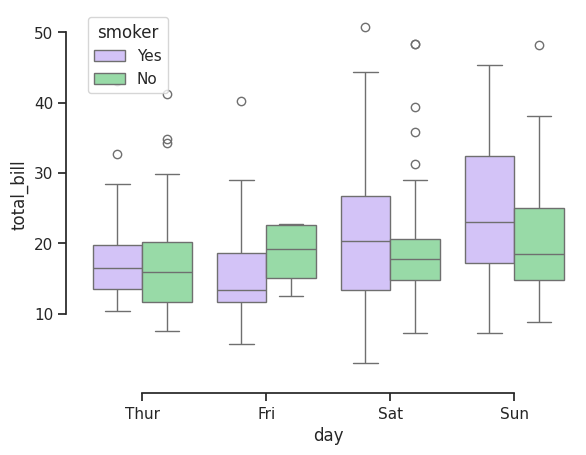

In [11]:
sns.set_theme(style="ticks", palette="pastel")

# Load the example tips dataset
tips = sns.load_dataset("tips")
print(tips)

# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="day", y="total_bill",
            hue="smoker", palette=["m", "g"],
            data=tips)
sns.despine(offset=10, trim=True)

## Code RN2483
Insérez les codes développés dans les TP précédents dans les cellules ci dessous.  
Vous n'êtes pas obligés de respecter un duty cycle pour récupérer les les trames.  
**Mettez seulement un temps d'attente afin d'éviter trop de collisions.**

In [12]:
#Configuration
PORT     = '/dev/ttyACM0'
BAUDRATE = 57600
logger= logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("Test")

NameError: name 'logging' is not defined

In [ ]:






def setup_serial(port:str=PORT,baudrate:int=BAUDRATE,bytesize:int=serial.EIGHTBITS,
                        parity:str=serial.PARITY_NONE,stopbits:int=serial.STOPBITS_ONE,
                        dtr:int=False):
    """
    Function to setup my serial connection
    Params:
        port:str        : Port used for my connection, default value PORT
        baudrate:int    : Baudrate, default value BAUDRATE
        bytesize:int    : bytesize, default value serial.EIGHTBITS
        parity:str      : Bit parity, default value serial.PARITY_NONE
        stopbits:int    : Stop bits, default value serial.STOPBITS_ONE
        dtr:bool        : Data Terminal Ready, default value False
    Returns :
        sp:Serial.Serial: A serial connection
    """
    try:
        sp = serial.Serial()
        sp.port = port
        sp.baudrate = baudrate
        sp.bytesize = bytesize
        sp.parity = parity
        sp.stopbits = stopbits
        sp.dtr=dtr
        sp.open()
        return sp
    except (ValueError,serial.SerialException) as exception:
        logging.critical("Could not open the serial connection.")
        raise exception
#Test de connexion
module = setup_serial()
def send(sp:serial.Serial,data:str):
    """
    Send data through the serial connection
        Param:
            sp:serial.Serial : serial.Serial object used for the RN2485
            data:str : Data to encode and send
        Returns :
            decoded_response:str: Returns a response if got one
    """
    #Encode data and send it through the serial connection
    data_to_send = (data.rstrip()+"\x0d\x0a").encode()
    sp.write(data_to_send)
    time.sleep(0.2)

    #Wait for a response
    rdata=sp.readline()
    while not rdata:
        rdata = sp.readline()

    #Decode response and send it
    decoded_response = rdata.strip().decode()
    logging.debug("Decoded response : %s",decoded_response)
    return decoded_response
def reset_module(sp):
    """cnf
    Reset the module
    sys reset : This command resets and restarts the RN2483 module; stored LoRaWAN protocol
    settings will be loaded automatically upon reboot.
        Param:
        Returns :
            response:str : Response from the module
            response from the module : RN2483 X.Y.Z MMM DD YYYY HH:MM:SS, where X.Y.Z is firmware
            version, MMM is month, DD is day, YYYY is year, HH:MM:SS is hour,
            minutes, seconds (format: [HW] [FW] [Date] [Time]). [Date] and [Time] refer
            to the release of the firmware.
            
    """
    #Send the command to reset the module
    command = "sys factoryRESET"
    response = send(sp,command)
    return response
def set_appkey(sp,appkey:str):
    """
    Set the APPKEY
    mac set appkey <appKey> : 
        - This command sets the application key for the module. The application key is used tocnf
          derive the security credentials for communication during over-the-air activation.
        Param:
            <appKey>: 16-byte hexadecimal number representing the application key
        Returns :
            Response from module: 
                    - ok if key is valid
                    - invalid_param if key is not valid
    """
    #Send the command to set the appkey
    command = "mac set appkey "+appkey
    response = send(sp,command)
    return response
def set_joineui(sp,joineui:str):
    """
    Set the JOINEUI
    mac set appeui <appEUI>
        This command sets the 
        Param:
                ??
        Returns :
            Response: ok if address is valid
            invalid_param if address is not valid
    """
    #Send the command to set the joineui
    command = "mac set appeui " +joineui
    response = send(sp,command)
    return response
def set_datarate(sp,spreading_factor:int):
    """
    Set the datarate
    mac set dr <dataRate>
    This command sets the data rate to be used for the next transmission. 
        Param:
            <dataRate>: decimal number representing the data rate, from 0 and 7, 
            but within the limits of the data rate range for the defined channels.
        Returns :
            Response: ok if data rate is valid or invalid_param if data rate is not valid
    """
    datarate = "DR0" #Find the relation between SF and DR
    #Send the command to set the datarate
    command = "mac set dr "+ str(spreading_factor)
    response = send(sp,command)
    return response
def set_deveui(sp,deveui:str):
    """
    Set the DEVEUI
    mac set deveui <devEUI>
        This command sets the globally unique device identifier for the module. The identifier
        must be set by the host MCU. The module contains a pre-programmed unique EUI and
        can be retrieved using the sys get hweui command (see Section 2.3.6.4) or user
        provided EUI can be configured using the mac set deveui command.
        Param:
            <devEUI>: 8-byte hexadecimal number representing the device EUI
        Returns :
            Response: ok if address is valid ou invalid_param if address is not validcnf
    """
    #Send the command to set the deveui
    command = "mac set deveui " + deveui
    response = send(sp,command)
    return response
def set_datarate(sp,spreading_factor:int):
    """
    Set the datarate
    mac set dr <dataRate>
    This command sets the data rate to be used for the next transmission. 
        Param:
            <dataRate>: decimal number representing the data rate, from 0 and 7, 
            but within the limits of the data rate range for the defined channels.
        Returns :
            Response: ok if data rate is valid or invalid_param if data rate is not valid
    """
    datarate = "DR0" #Find the relation between SF and DR
    #Send the command to set the datarate
    command = "mac set dr " + str(spreading_factor)
    response = send(sp,command)
    return response
def save_config(sp):
    """
    The mac save command must be issued after configuration parameters have been
    appropriately entered from the mac set <cmd> commands. This command will save
    LoRaWAN Class A protocol configuration parameters to the user EEPROM. When the
    next sys reset command is issued, the LoRaWAN Class A protocol configuration will
    be initialized with the last saved parameters.
        Param:
        Returns :
            Response: ok
    """
    #Send the command to save the current config
    command = "mac save"
    response = send(sp,command)
    return response
def config_module(sp,appkey:str,joineui:str,deveui:str,spreading_factor:int):
    """
    Configurate the module
        Param:
            spreading_factor:int : ???????????
            joineui:str          : ???????????
            deveui:str           : ???????????
            spreading_factor:int : ???????????
        Returns :
            bool: True if joined, False if not
    """
    logging.info("Resetting device")
    #response = send(sp, "sys reset")
    logging.debug("Response : %s",reset_module(sp))
    
    logging.info("Setting APPKEY : %s",appkey)
    #response = send(sp, f"mac set appkey {appkey}")
    logging.debug("Response : %s",set_appkey(sp, appkey))
    
    logging.info("Setting JOINEUI : %s",joineui)
    #response = send(sp, f"mac set joineui {joineui}")
    logging.debug("Response : %s",set_joineui(sp,joineui))
    
    logging.info("Setting DEVEUI : %s",deveui)
    #response = send(sp, f"mac set deveui {deveui}")
    logging.debug("Response : %s",set_deveui(sp,deveui))
    
    logging.info("Setting the data-rate, spreading_factor = %s",spreading_factor)
    #response = send(sp, f"mac set dr {spreading_factor}")
    logging.debug("Response : %s",set_datarate(sp,spreading_factor))
    
    logging.info("Saving mac settings")
    #response = send(sp, "mac save")
    logging.debug("Response : %s",save_config(sp))
    
    #Here we disable the duty cycle limit on the module to avoid errors
    #This part is given
    for channel in range(0,3):
        #Change duty cycle
        logging.info("Setting channel %s duty cycle to  1.00",channel)
        response = send(sp,f"mac set ch dcycle {channel} 1")
        logging.info("Set %s to dcycle response : %s",channel,response)
        #Channel status to on
        logging.info("Setting channel %s to on",channel)
        response = send(sp,f"mac set ch status {channel} on")
        logging.info("Set %s on response : %s",channel,response)
    
    
    #Now we join the network, this part is given
    joining=False
    while not joining:
        logging.info("Preparing to join the network")
        response = send(sp,"mac join otaa")
        logging.info("Mac join otaa response : %s",response)
        if "ok" in response:
            joining=True
        time.sleep(2)
        
    logging.info("Wating to get the accepted response")
    time.sleep(2) #Wait for accepted response
    ret = sp.readline()
    while not ret:
        ret = sp.readline()
    response = ret.strip().decode()
    logging.info("Status of the join request : %s",response)
    if not "accepted" in response:
        return False
    return True
#Test de la fonction
response = config_module(module,"0123456789ABCDEF0123456789ABCDEF","DEAD25DEAD25DEAD","DEADDEAD00090007",3)
logging.info("Did we join the network ? %s",response)
#verefication de bon sf 
logging.info("Getting SF : %s")
response = send(module, f"radio get sf ")
logging.debug("Response : %s",response)

def send_message(sp, message: bytes):
    """
    Send a message to the LoRa Network Server
    Param:
    sp: serial.Serial : serial.Serial object used for the RN2483
    message: str : Message to send
    Returns :
    response: str : Response from the module
    """
    # Prepare the message to be sent
    command = f"mac tx uncnf 1 {message}"
    print(command)
    response = send(sp, command)
    return response


# Questions préliminaires

**Qu'est-ce que le SF ?**

Le SF (Spreading Factor) est un paramètre dans les réseaux LoRaWAN, il définit la durée de transmission d'un paquet de données sur un canal donné. Il influence directement la portée du signal et la consommation énergétique, tout en affectant le débit de données. Il va de 7 à 12.

**Qu'est-ce que le RSSI ? Quelle est son unité ? Pourquoi est-ce important dans ce TP ?**

Le RSSI (Received Signal Strength Indicator) est un indicateur de la puissance du signal reçu par un dispositif. Il mesure la force du signal radio capté par un récepteur et est exprimé en dBm (décibels milliwatts). Plus le RSSI est élevé, plus le signal est fort.
Le RSSI permet d'évaluer la qualité de la connexion entre un appareil et la passerelle.

**Qu'est-ce que le SNR ? Quelle est son unité ? Pourquoi est-ce important dans ce TP ?**

Le SNR (Signal-to-Noise Ratio), ou rapport signal sur bruit en français, est une mesure de la qualité d'un signal par rapport au bruit de fond. Il évalue la proportion entre l'intensité du signal utile et celle du bruit qui peut interférer avec ce signal. Plus le SNR est élevé, plus le signal est clair et moins il y a d'interférence.

# Partie 1 : Récupération de trames.
Dans cette partie, récupérez une trentaine de trames LoRaWAN pour chaque SF. Enregistrez les dans un fichier pour pouvoir les réutiliser dans la partie 2.


Rappel :  
Le LoRa Network Server (ou LNS) est configuré pour publier les messages reçus vers le topic : 
`TestTopic/lora/{appid}/{deveui}/{event}`  
A l'aide de mosquitto_sub, vous allez **subscribe** à ce topic depuis une console grâce à la commande suivante :  
`mosquitto_sub -h neocampus.univ-tlse3.fr -t TestTopic/lora/{appid}/{deveui}/# -p 1882 -u test -P test`

Le broker MQTT neOCampus utilise le port 1882. En général, les brokers MQTT utilisent le port 1883. On précise le broker grâce à l'argument `-p` dans la commande ci dessus. 
**Si vous essayez d'accéder au broker depuis un réseau externe à l'université, il faudra utiliser le port 10882**

In [ ]:
import paho.mqtt.client as mqtt
import logging

# Configuration des paramètres MQTT
MQTT_BROKER = "mqtt.example.com"  # Remplace par l'adresse de ton broker MQTT
MQTT_PORT = 1883  # Port par défaut MQTT
MQTT_TOPIC = "lora/device_data"  # Le sujet auquel tu souhaites t'abonner

# Fonction qui sera appelée lorsque le client MQTT se connecte au broker
def on_connect(client, userdata, flags, rc):
    logging.info(f"Connected with result code {rc}")
    # S'abonner au sujet (topic)
    client.subscribe(MQTT_TOPIC)
    logging.info(f"Subscribed to topic: {MQTT_TOPIC}")

# Fonction qui sera appelée lorsqu'un message est reçu sur le sujet
def on_message(client, userdata, msg):
    logging.info(f"Message reçu sur le sujet {msg.topic}: {msg.payload.decode()}")
    # Traite ici le message reçu
    # Par exemple, afficher les données ou les enregistrer dans un fichier

# Fonction principale pour configurer et démarrer le client MQTT
def start_mqtt_client():
    # Créer une instance du client MQTT
    client = mqtt.Client()

    # Définir les fonctions de callback pour la connexion et la réception de messages
    client.on_connect = on_connect
    client.on_message = on_message

    # Se connecter au broker MQTT
    logging.info(f"Connecting to MQTT broker {MQTT_BROKER}:{MQTT_PORT}")
    client.connect(MQTT_BROKER, MQTT_PORT, 60)

    # Boucle infinie pour maintenir la connexion et recevoir les messages
    client.loop_forever()

# Démarrer le client MQTT
if __name__ == "__main__":
    logging.basicConfig(level=logging.INFO)
    start_mqtt_client()


# Partie 2 : Analyse 
Dans cette partie, vous allez réutiliser les trames enregistrées lors de la partie 1.  
Quand vous traitez les trames, intéressez vous aux valeurs de la **best_gateway**.  

Si le résultat que vous obtenez n'est pas celui auquel vous vous attendiez, essayez de justifier pourquoi.

## RSSI

**Selon vous,quel comportement est attendu du RSSI quand on fait varier le SF ?**

**Tracez un graphe *(boxplot)* du RSSI en fonction du SF.**

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# List of file paths for the JSON files
file_paths = [
    '/json_file/tp_json_sf0.json',
    '/json_filetp_json_sf1.json',
    '/json_file/tp_json_sf2.json',
    '/json_file/tp_json_sf3.json',
    '/json_file/tp_json_sf4.json',
    '/json_file/tp_json_sf5.json',
]

# Load and extract data from each file
all_data = []
for path in file_paths:
    with open(path, 'r') as file:
        data = json.load(file)
        for record in data:
            best_gw = record.get("best_gw", {})
            rssi = best_gw.get("rssi")
            datr = record.get("datr")
            # Parse the SF (Spreading Factor) from datr
            if datr.startswith("SF")and datr[2:4].isdigit():
                sf = int(datr[2:4])  # Extract SF value (e.g., "SF12BW125" -> 12)
                all_data.append({"RSSI": rssi, "SF": sf})
            else:
                sf = int(datr[2:3])
                all_data.append({"RSSI": rssi, "SF": sf})

# Create a DataFrame from the extracted data
df_combined = pd.DataFrame(all_data)
#print(df_combined)
# Plot the boxplot of RSSI values by SF
plt.figure(figsize=(12, 8))
df_combined.boxplot(column="RSSI", by="SF", grid=False)
plt.title("Boxplot of RSSI by SF Across All Files")
plt.suptitle("")  # Suppress the default title
plt.xlabel("Spreading Factor (SF)")
plt.ylabel("RSSI (dBm)")
plt.xticks(rotation=45)
plt.show()


: 

**Commentez le graphe. Que pouvez vous conclure ? Est-ce ce à quoi vous vous attendiez ? Pourquoi ?**

## SNR

**Selon vous,quel comportement est attendu du SNR quand on fait varier le SF ?**

**Tracez un graphe *(boxplot)* du SNR en fonction du SF.**

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# List of file paths for the JSON files
file_paths = [
    '/json_file/tp_json_sf0.json',
    '/json_filetp_json_sf1.json',
    '/json_file/tp_json_sf2.json',
    '/json_file/tp_json_sf3.json',
    '/json_file/tp_json_sf4.json',
    '/json_file/tp_json_sf5.json',
]

# Load and extract data from each file
all_data = []
for path in file_paths:
    with open(path, 'r') as file:
        data = json.load(file)
        for record in data:
            best_gw = record.get("best_gw", {})
            lsnr = best_gw.get("lsnr")
            datr = record.get("datr")
            # Parse the SF (Spreading Factor) from datr
            if datr.startswith("SF")and datr[2:4].isdigit():
                sf = int(datr[2:4])  # Extract SF value (e.g., "SF12BW125" -> 12)
                all_data.append({"LSNR": lsnr, "SF": sf})
            else:
                sf = int(datr[2:3])
                all_data.append({"LSNR": lsnr, "SF": sf})

# Create a DataFrame from the extracted data
df_combined = pd.DataFrame(all_data)
#print(df_combined)
# Plot the boxplot of RSSI values by SF
plt.figure(figsize=(12, 8))
df_combined.boxplot(column="LSNR", by="SF", grid=False)
plt.title("Boxplot of LSNR by SF Across All Files")
plt.suptitle("")  # Suppress the default title
plt.xlabel("Spreading Factor (SF)")
plt.ylabel("LSNR ")
plt.xticks(rotation=45)
plt.show()


**Commentez le graphe. Que pouvez vous conclure ? Est-ce ce à quoi vous vous attendiez ? Pourquoi ?**

## Data Extraction Rate de chaque gateway pour chaque SF
Dans cette partie, on vous demande le % de messages captés par chaque gateway pour chaque SF.

**Selon vous, que va entrainer la modification du SF ? Quel SF utiliser pour maximiser le DER ?**

**Tracez un graphe *(boxplot)* du DER de chaque gateway en fonction du SF.**

In [ ]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Liste des chemins vers les fichiers JSON
file_paths = [
    '/json_file/tp_json_sf0.json',
    '/json_filetp_json_sf1.json',
    '/json_file/tp_json_sf2.json',
    '/json_file/tp_json_sf3.json',
    '/json_file/tp_json_sf4.json',
    '/json_file/tp_json_sf5.json',
]

# Charger et extraire les données de chaque fichier
all_data = []
for path in file_paths:
    with open(path, 'r') as file:
        data = json.load(file)
        for record in data:
            all_gw = record.get("all_gw", [])  # Liste des gateways captant le message
            datr = record.get("datr")  # Facteur d'étalement (SF)
            if datr.startswith("SF") and datr[2:4].isdigit():
                sf = int(datr[2:4])  # Extraire le SF (par exemple, "SF12BW125" -> 12)
                for gw in all_gw:
                    gateway_desc = gw.get("desc", "Unknown")  # Description de la gateway
                    all_data.append({"SF": sf, "Gateway": gateway_desc})
            else:
                sf = int(datr[2:3])  # Extraire le SF (par exemple, "SF12BW125" -> 12)
                for gw in all_gw:
                    gateway_desc = gw.get("desc", "Unknown")  # Description de la gateway
                    all_data.append({"SF": sf, "Gateway": gateway_desc})
               


# Créer un DataFrame à partir des données extraites
df = pd.DataFrame(all_data)

# Vérifier les données extraites
print("Aperçu des données :")
print(df.head())

# Calculer le nombre total de messages captés par chaque gateway pour chaque SF
message_counts = df.groupby(["SF", "Gateway"]).size().reset_index(name="MessageCount")
print("hahahahahahahah")
print(message_counts)
# Ajouter un pourcentage des messages captés pour chaque SF
total_messages_per_sf = message_counts.groupby("SF")["MessageCount"].transform("sum")
message_counts["Percentage"] = (message_counts["MessageCount"] / total_messages_per_sf) * 100

# Afficher les résultats finaux
print("Pourcentage des messages captés par chaque gateway pour chaque SF :")


# Visualisation avec Seaborn (Grouped Barplot)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 8))

sns.barplot(
    data=message_counts,
    x="SF",          # Axe X : SF
    y="Percentage",  # Axe Y : Pourcentage des messages
    hue="Gateway",   # Groupement par Gateway
    palette="Set2"   # Palette des couleurs
)

# Ajustements esthétiques
plt.title("Pourcentage des messages captés par Gateway pour chaque SF")
plt.xlabel("Spreading Factor (SF)")
plt.ylabel("Pourcentage des messages (%)")
plt.legend(title="Gateway", loc="upper right")
plt.xticks(rotation=45)
plt.tight_layout()

# Afficher le graphique
plt.show()


**Commentez le graphe. Que pouvez vous conclure ? Est-ce ce à quoi vous vous attendiez ? Pourquoi ?**

# Distance

Le lien ci-dessous permet de voir où sont situées les gateways.  
**A quelle distance étiez vous des gateways quand vous émettiez ?**

https://www.google.com/maps/d/u/0/edit?mid=1oBEwKLwUyCBqnEczIpG0BARMm9NM1a0&usp=sharing 

**La distance joue-t-elle un rôle sur le RSSI et le SNR ? Expliquez.**

**La distance joue-t-elle un rôle dans le choix du SF ? Que pouvez vous en conclure ?**

**En plus du SF, pouvez vous citer d'autres paramètres importants afin d'optimiser les transmissions LoRaWAN ?**